
# Notes from The spelled-out intro to neural networks and backprogagation: building micrograd


## Disclaimer

I did not come up with any of this code myself! (Except for the Custom Gradient function). This is followed along from Andrej Karpathy's YouTube video: [The spelled-out intro to neural networks and backprogagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ)

## Part 1: Intro


Micrograd is an Autograd Engine, which implements the Backpropagation algorithm.
The backpropagation algorithm efficiently evaluates the gradient of the loss function with respect to the weights and biases of a neural network.



## Part 2: The Value Object


Andrej implements a class Value

In [11]:
import math

class Value:
  """
  Definition of the Value object

  Note: the following methods are specially recognized 
  by python to allow the use of '+', '*', etc. operators.

  Note: __repr__ method allows nice printing for the object.

  ...

  Attributes
  ----------
  data : number
    The value of the number that the Value object represents
  grad : number
    The value of the gradient
  _backward : functino
    A function to assign the value of the gradient based on the mathematical operation involved with the value.
  _prev : Value
    The value that is the outcome of this Value and an operation
  _op : str
    A string representation of the mathematical operation this Value is inputted into
  label : str
    String label to display on the graph visualizations.

  Methods
  -------
  __repr__(self)
    Defines output of print(Value val) for some Value object
  __add__(self, other)
    Returns a Value with data field equal to the summation of self.data and other.data
  __mul__(self, other)
    Returns a Value with data field equal to the product of self.data and other.data
  __pow__(self, other)
    Returns a Value with data field equal to self.data to the power of other.data
  __truediv__(self, other)
    Returns a Value with data field equal to self.data divided by other.data
  tanh(self)
    implements the hyperbolic tangent function of a Value
  exp(self):
    Returns a Value with data field e^(self.data)
  __neg__(self):
    Returns a Value with data field -1 * self.data
  __sub__(self, other)
    Returns a Value with data field self.data - other.data
  __rmul__(self, other)
    calls __mul__(other, self)
  __radd__(self,other)
    Calls __add__(other, self)
  backward(self):
      Performs topological sort on nodes to set order of
      execution of backpropogation, to ensure that 
      parents' gradients are computed before self's
      Note: Backpropogation will execute in reverse-
      topological order.  
  """



  def __init__(self, data, _children=(), _op='', label=''):
    """
    @brief initializes the fields of a Value object.

    note: set of children is entered as a tuple, but is casted to a set
    when the Value object is  initialized.

    @param data : input number for value to represent
    @param _children : tuple of Values that created self Value
    @ param 
    """
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label



  def __repr__(self):
    """
    __repr__() allows print(a) of Value type to be recognized.
    """
    return f"Value(data={self.data})"



  def __add__(self, other):
    """
    __add__() allows a + b to be recognized as Value(a.data + b.data).

    Notice how the tuple (self,other) get passed into 
    the _children field of the newly created Value 'out'.
    """
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self,other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward

    return out



  def __mul__(self, other):
    """
    __mul__() allows multiplication operator on Value types
    """
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self,other), '*')

    def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
  
    out._backward = _backward
    
    return out



  def __pow__(self,other):
    """
    Implements powers of integers and floats.
    """
    assert isinstance(other, (int, float)), "ensuring only ints or floats"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * self.data**(other-1) * out.grad

    out._backward = _backward

    return out



  def __truediv__(self,other):
    """
    Implements division by reusing __mul__ and __pow__.
    """
    return self * other**-1



  def tanh(self):
    """
    implements the hyperbolic tangent function of a Value
    """
    x = self.data
    y = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(y, (self, ), 'tanh', "tanh(%s)" % self.label)

    def _backward():
      self.grad += (1 - y**2) * out.grad

    out._backward = _backward
    return out
  

  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad
      # dy(e^x)/dx = y'(e^x) * d(e^x)/dx
      #            = dy/dx * e^x = out.grad * e^x

    out._backward = _backward

    return out


  def __neg__(self):
    """ 
    __neg__() allows the use of -a to be recognized as -1*a
    """
    return self * -1



  def __sub__(self, other):
    """
    __sub__() allows subtraction between Value types
    """
    return self + -other



  def __rmul__(self, other): # other * self
    """
    calls the __mul__ function of the second product

    ex. 1 * a is read as 1.__mul__(a), where __mul__ here
    is the integer type's multiplication function, which is 
    not compatible with type Value. When that fails,
    __rmul__() is called, which then calls a.__mul__(1),
    which uses Value's __mul__ function, which is compatible
    with type integer.
    """
    return self * other

  def __radd__(self,other): # other + self
    return self + other


  def backward(self):
    """
      Computes Gradients
      
      Performs topological sort on nodes to set order of
      execution of backpropogation, to ensure that 
      parents' gradients are computed before self's
      Note: Backpropogation will execute in reverse-
      topological order.

      Then, computes the gradients of each node in
      reverse-topological order.
    """
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    #### Set base case: gradient of = 1.0
    self.grad = 1.0
    build_topo(self)

    #### Compute gradients in topological order
    for node in reversed(topo):
      node._backward()

In [12]:

a = Value(4.0)
b = Value(2.0)

## Part 3: Network Visualization

In [13]:
from graphviz import Digraph

def trace(root):
  """
  Builds a graph as sets of all nodes and edges in a network

  Since this is a feed-forward network, it is a DAG and is 
  very straight-forward to implement a recursive graph-build function.
  """
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        # if (child,v) not in edges:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  # gradient(root,0.0)
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, make a rectangular 'record' node for it
    dot.node(name = uid, label = "{ %s | data %.3f | grad %.3f }" % (n.label, n.data, n.grad), shape = 'record')
    # Math operator node
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      # Connect node to its operator
      dot.edge(uid + n._op, uid)

      for c in n._prev:
      #   # Connect n1 to operator node of n2
        if len(n._prev):
          dot.edge(str(id(c)), str(id(n)) + n._op)
  return dot



### Custom Gradient function

In [14]:
### Custom Gradient Function
def gradient(root: Value):
  # base case: 

  # set parents gradient

  # Case 1: adding or multiplying
  if root._op == '*' or root._op == '+':
    (n1, n2) = root._prev
    if root._op == '*':
      n1.grad = n2.data*root.grad
      n2.grad = n1.data*root.grad
    else:
      n1.grad = root.grad
      n2.grad = root.grad
    gradient(n1)
    gradient(n2)

  # Case 2: tanh function
  elif root._op == 'tanh':
    (n,) = root._prev
    n.grad = 1 - root.data**2
    gradient(n)


## Part 4: The tanh Function

### Tanh

Text(0.5, 1.0, 'tanh')

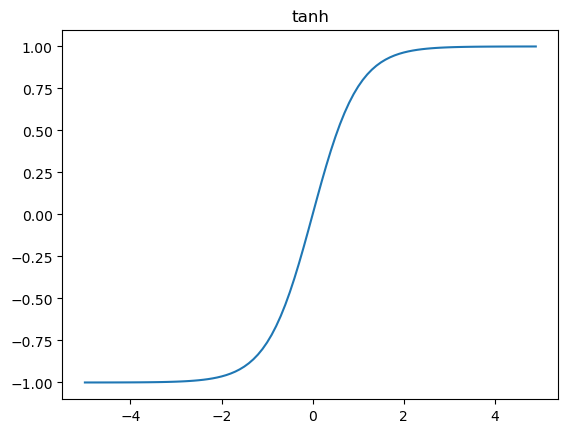

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def tanh(x):
  return (np.exp(2*x) - 1)/(np.exp(2*x) + 1)
x = np.arange(-5,5, 0.1)
plt.plot(x, tanh(x))
plt.title('tanh')

### Derivative of Tanh overlayed with 1- tanh(x)^2

Text(0.5, 1.0, 'derivative of tanh')

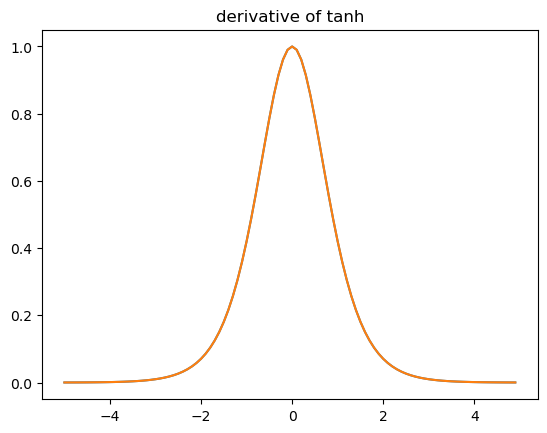

In [16]:
h = 0.0001
plt.plot(x, (tanh(x+h)-tanh(x))/h, x, 1 - tanh(x)**2)
plt.title('derivative of tanh')

We can see that d/dx of tanh is equal to 1 - tanh^2

## Part 5. Visualize single neuron with two inputs

### Using .tanh() method

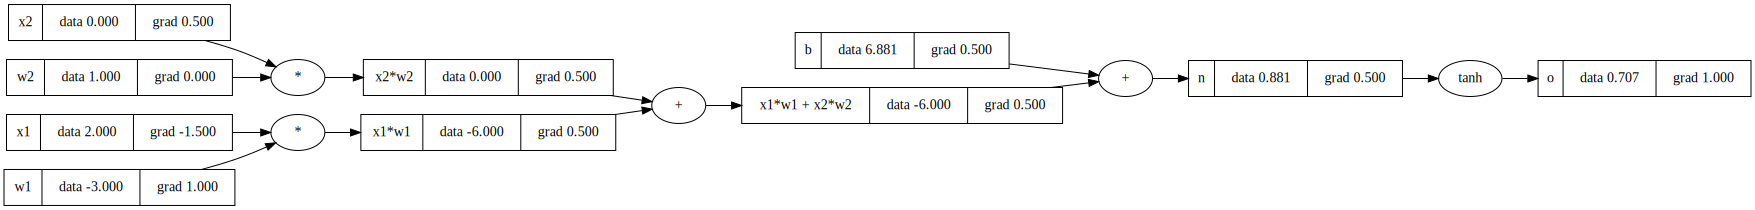

In [17]:
from numpy.lib.nanfunctions import nanargmax
#### Initialize the variables for this neuron
x1= Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o'
#-----
o.backward()
draw_dot(o)

### Using Exponentials to represent tanh()

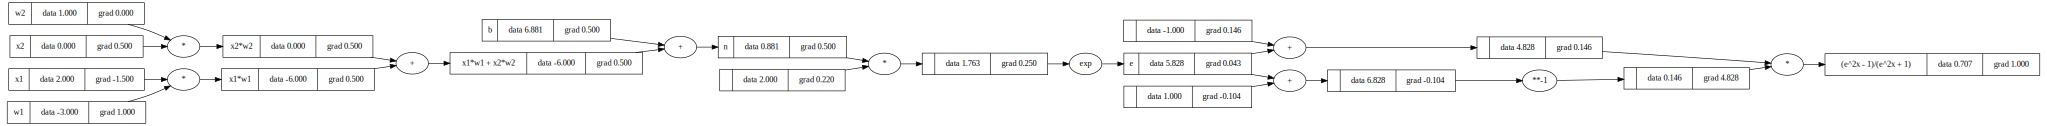

In [18]:
#### Initialize the variables for this neuron
x1= Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'
e = (2*n).exp(); e.label='e'
o = (e - 1) / (e + 1); o.label = '(e^2x - 1)/(e^2x + 1)'

o.backward()
draw_dot(o)

## Part 6: PyTorch and Multi-Layered Perceptrons

### PyTorch Basics

In [19]:
import torch
torch

<module 'torch' from '/home/kyle/anaconda3/lib/python3.9/site-packages/torch/__init__.py'>

In [20]:
x1 = torch.Tensor([2.0]).double()                 ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                 ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                 ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()   ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # output is same as above
o.backward()

print('----')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
x1 -1.5000003851533106
w1 1.0000002567688737
w2 0.0


### Implementing the MLP

In [21]:
import random

class Neuron:
  """Initialize n-inputs and 1 bias
  """
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w dot x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), start=self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    """
    initialize a list of neurons as a layer
    @param nin: size of prev layer
    @param nout: number of outputs (number of neurons in layer)
    """
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    """
    spit out a list of ordered activations corresponding to the 
    list of ordered neurons in the layer
    """
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    # Single list comprehension method that I don't understand:
    # return [p for n in self.neurons for p in n.parameters()]
    params = []
    for ron in self.neurons:
      ps = ron.parameters()
      params.extend(ps)
    return params

class MLP:

  def __init__(self, nin, nouts):
    """
    @param nin: size of input layer
    @param nouts: list of layer sizes, where the total number of 
    layers will be equal to len(nouts) + 1
    """
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

### Visualizing a four-layered network

In [22]:
# Visualize 4-layered neural network
x = [2.0, 3.0, 4.0]
n = MLP(3, [4, 4, 1])

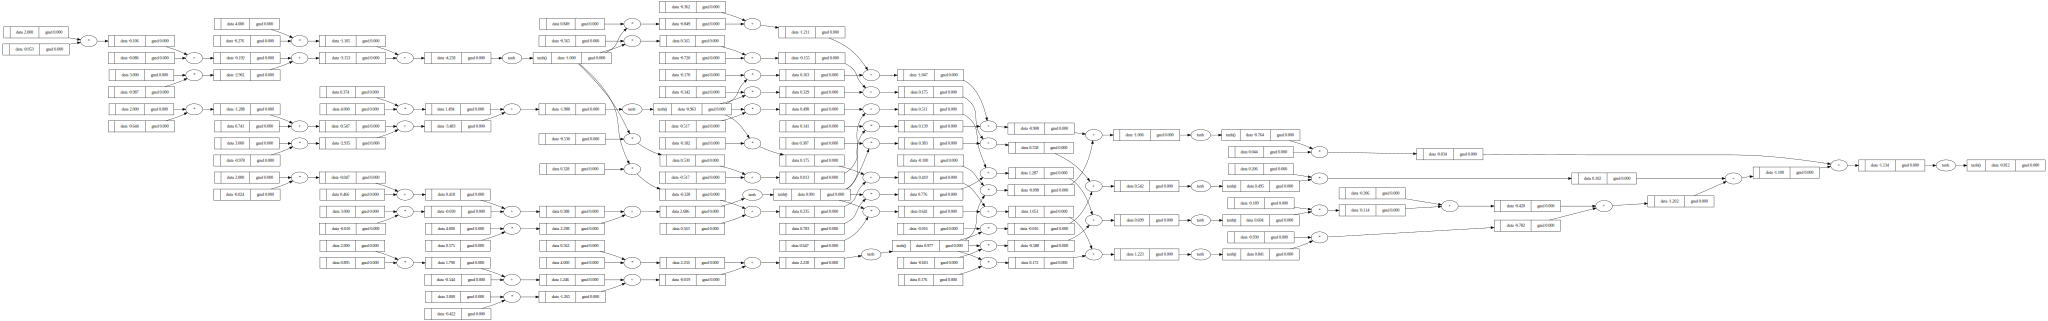

In [23]:
draw_dot(n(x))

In [24]:
# 3 inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# 3 desired outputs
ys = [1.0,-1.0,-1.0, 1.0]

ypred = [n(x) for x in xs]
ypred # untrained predictions

[Value(data=-0.550278354838704),
 Value(data=-0.8024216294016148),
 Value(data=-0.7776463862561311),
 Value(data=-0.6123045980130044)]

In [25]:
# squared error for 3 predictions
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys,ypred)])
loss

Value(data=5.091367436328545)

In [26]:
loss.backward()
n.layers[0].neurons[0].w[2].grad

-0.3309912264485383

### Visualizing the loss function

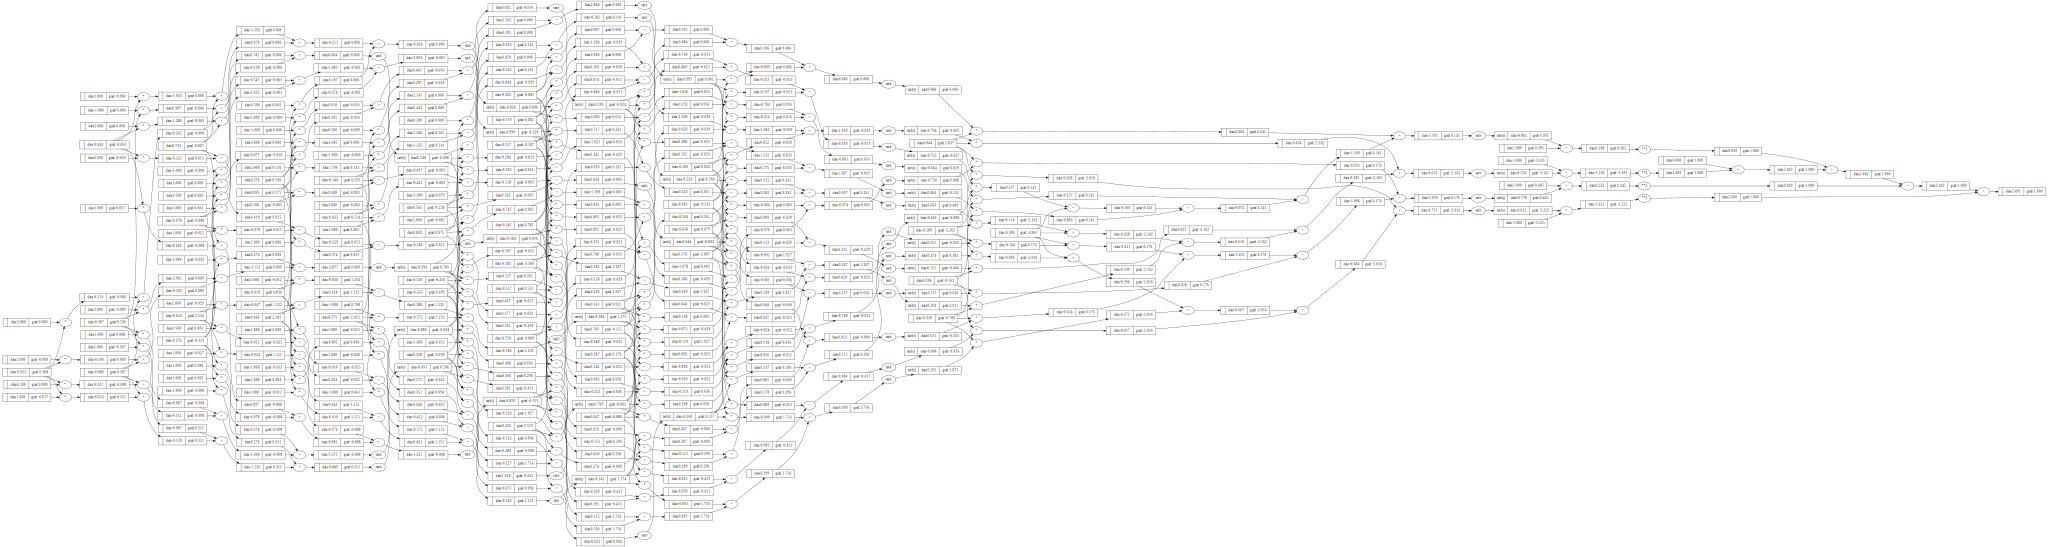

In [27]:
draw_dot(loss)

## Part 7. Gradient Descent

In [28]:

w0 = n.layers[0].neurons[0].w[0]
w0

Value(data=-0.05310915240621661)

In [29]:
eta = 0.01 # learning rate
for p in n.parameters():
  p.data -= eta * p.grad

In [30]:
w0


Value(data=-0.0561893310726567)

In the 3 cells above, I show that the value of the weight will either:

- decrease if its gradient is positive, or 
- increase if its gradient is negative

because the gradient represents the change in the loss relative to the change in the value of the weight.

### Training Loop

In [31]:
# Reinitialize
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0,-1.0,-1.0, 1.0]

x = [2.0, 3.0, 4.0]
n = MLP(3, [4, 4, 1])

In [32]:
iters = 100
eta = 0.05

for k in range(iters):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys,ypred)])
  # backward pass
  # reset grad to zero before calculating
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -eta * p.grad
  
  # print
  print('Iteration %d: loss: %f' % (k, loss.data))

print('\npredictions:', [round(n(x).data, 3) for x in xs])
print('actual values:', ys)

Iteration 0: loss: 6.809168
Iteration 1: loss: 4.829893
Iteration 2: loss: 2.314416
Iteration 3: loss: 0.965853
Iteration 4: loss: 0.353833
Iteration 5: loss: 0.198212
Iteration 6: loss: 0.154524
Iteration 7: loss: 0.126915
Iteration 8: loss: 0.107463
Iteration 9: loss: 0.092996
Iteration 10: loss: 0.081827
Iteration 11: loss: 0.072958
Iteration 12: loss: 0.065752
Iteration 13: loss: 0.059789
Iteration 14: loss: 0.054778
Iteration 15: loss: 0.050509
Iteration 16: loss: 0.046833
Iteration 17: loss: 0.043635
Iteration 18: loss: 0.040830
Iteration 19: loss: 0.038349
Iteration 20: loss: 0.036142
Iteration 21: loss: 0.034164
Iteration 22: loss: 0.032384
Iteration 23: loss: 0.030773
Iteration 24: loss: 0.029308
Iteration 25: loss: 0.027971
Iteration 26: loss: 0.026747
Iteration 27: loss: 0.025620
Iteration 28: loss: 0.024581
Iteration 29: loss: 0.023620
Iteration 30: loss: 0.022729
Iteration 31: loss: 0.021899
Iteration 32: loss: 0.021126
Iteration 33: loss: 0.020403
Iteration 34: loss: 0.01